# Model Order Reduction & Machine Learning - Project
## Nonlinear Elliptic problem POD vs PINNs

### Importing library

In [2]:
import sys
sys.path.append('../../CppToPython')

In [3]:
import numpy as np
import GeDiM4Py as gedim
from scipy.sparse.linalg import splu
import time

In [4]:
# Run to avoid to many warnings
import warnings
warnings.filterwarnings('ignore')

### Initialize

In [5]:
lib = gedim.ImportLibrary("../../CppToPython/release/GeDiM4Py.so")

config = { 'GeometricTolerance': 1.0e-8 }
gedim.Initialize(config, lib)

In [6]:
np.random.seed(23)

## PART 1
Let us consider the two-dimensional spatial domain $\Omega = (0, 1)^2$. We want to solve the following parametrized problem: given $\mu = (\mu_0, \mu_1) \in \mathcal{P} = [0.1, 1]^2$, find $u(\mu)$ such that
$$
-\Delta u(\mu) + \frac{\mu_0}{\mu_1} (e^{\mu_1 u(\mu)} - 1) = g(x;\mu),
$$
with homogeneous Dirichlet condition on the boundary, i.e. zero-boundary condition.

The forcing term, that does not depend on the parameters, defined as
$$
g(x;\mu) = g_1 = 100 \sin(2\pi x_0) \cos(2\pi x_1) \quad \forall x = (x_0, x_1) \in \Omega.
$$

**Tasks:**

1. Solve the problem by means of POD-Galerkin method over a Finite Element full order model -> using high fidelity element approximation of POD
2. Solve the problem with a parametric PINN -> find the NN structure to reduce the problem
3. Compare the two approaches in terms of computational costs and accuracy with respect to the full order model -> compare in terms of execution time & error
4. **Optional:** Solve the problem with the POD-NN approach and compare it to the other two strategies.

# AGGIUSTARE QUA IN ACCORDO AI PASSAGGI FATTI SOPRA
#### Analisys of all the term of the system

$$\left( \int_{\Omega} \nabla \delta u_k \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 u_k} \delta u_k v \, dX \right) * \delta u = - \left( \int_{\Omega} \nabla u_k \cdot \nabla v \, dX + \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u_k} -1) v \, dX - \int_{\Omega} g v \, dX \right)$$

1. Left-hand side (Jacobian applied to Newton increment):
       
    **Diffusion term**:  $
      \int_{\Omega} \nabla \delta u_k \cdot \nabla v \, dX
      $
      
    **Nonlinear reaction term** (derivative of the exponential term):  $
      \int_{\Omega} \mu_0 e^{\mu_1 u_k} \delta u_k v \, dX
      $

2. Right-hand side (Nonlinear residual at step \( u_k \)):

    **Diffusion term**:  $
      \int_{\Omega} \nabla u_k \cdot \nabla v \, dX
      $
      
    **Nonlinear reaction term**:  $
      \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u_k} -1) v \, dX
      $
      
    **Source term**:  $
      \int_{\Omega} \tilde{g} v \, dX
      $

### Passage from Strong Formulation to Weak Formulation and Newton Scheme for the EXACT SOLUTION

# DA AGGIUNGERE I PASSAGGI FATTI
**AGGIUNGI CALCOLI FATTI A MANO -**

As a preliminar step, to evaluate the error of the solution computed using Newton method, we will apply the Newton algorithm to solve a PDE of which we know the exact solution. In particular, we'll consider an exact solution $\tilde{u}$ and compute the forcing term $\tilde{g}$ st it is solution to our differential problem. Then, we will solve the PDE using the Netwon schema and evaluate the error of the approximation of $\tilde{u}$ wrt the exact solution.

Take the exact solution 
$$\tilde{u}(x,y;\mu)= \mu_0xy(1-x)(1-y)$$
and compute the forcing term $\tilde{g}(x,y;\mu)$ st $$-\Delta \tilde{u}(\mu) + \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}(\mu)} - 1) = \tilde{g}(x, y;\mu)$$
To do so, compute the laplacian of $\tilde{u}$: $$\Delta \tilde{u}(\mu) = -2 \mu_0 (y(1-y) + x(1-x))$$ and substitute $\tilde{u}$ in the non linear term of the PDE : $$\frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}(\mu)} - 1) = \frac{\mu_0}{\mu_1} (e^{\mu_1 \mu_0xy(1-x)(1-y)} - 1 ) $$

Then, the forcing term for this problem is $$\tilde{g}(x,y;\mu) = 2 \mu_0 (y(1-y) + x(1-x)) + \frac{\mu_0}{\mu_1} (e^{\mu_1 \mu_0xy(1-x)(1-y)} - 1) $$

Now consider the parametric PDE $-\Delta \tilde{u}(\mu) + \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}(\mu)} - 1) = \tilde{g}(x, y;\mu)$.

**Weak Formulation.**
Find $\tilde{u} \in H_0^1(\Omega)$ such that for every $v \in H_0^1(\Omega)$:
$$\int_{\Omega} \nabla \tilde{u} \cdot \nabla v \, dX + \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}} -1) v \, dX - \int_{\Omega} \tilde{g} v \, dX = 0$$
Hence, the weak formulation is:
$$\int_{\Omega} \nabla \tilde{u} \cdot \nabla v \, dX + \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}} -1) v \, dX = \int_{\Omega} \tilde{g} v \, dX$$
where on the left can be found the unkown $\tilde{u}$ and on the right the forcing term.

**Definition of the Nonlinear Operator.**
Define the operator $F: H_0^1(\Omega) \to (H_0^1(\Omega))'$ such that for $u \in H_0^1(\Omega)$ and $v \in H_0^1(\Omega)$:
$$F(u)[v] = \int_{\Omega} \nabla u \cdot \nabla v \, dX + \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u} -1) v \, dX - \int_{\Omega} g v \, dX$$
Solving the PDE means finding $\tilde{u}$ st $F(\tilde{u})[v]=0$ for every $v$, which we solve using the Newton schema.

**Fréchet Derivative of $F(u)$.**
Calculate the Fréchet derivative $DF(u)[\delta u] \in (H_0^1(\Omega))'$ for an increment $\delta u \in H_0^1(\Omega)$. For every $v \in H_0^1(\Omega)$:
$$DF(u)[\delta u][v] = \lim_{\epsilon \to 0} \frac{F(u + \epsilon \delta u)[v] - F(u)[v]}{\epsilon}$$
Consider each term of $F(u)[v]$ separately.

1.  **Linear Term.** $F_1(\tilde{u})[v] = \int_{\Omega} \nabla \tilde{u} \cdot \nabla v \, dX$.
    $$DF_1(\tilde{u})[\delta \tilde{u}][v] = \int_{\Omega} \nabla \delta \tilde{u} \cdot \nabla v \, dX$$

2.  **Nonlinear Term.** $F_2(\tilde{u})[v] = \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}} -1) v \, dX$.
    The Fréchet derivative of $F_2(u)$ is given by:
    $$DF_2(\tilde{u})[\delta \tilde{u}][v] = \lim_{\epsilon \to 0} \frac{F_2(\tilde{u} + \epsilon \delta \tilde{u})[v] - F_2(\tilde{u})[v]}{\epsilon}$$
    **Expansion of $F_2(\tilde{u} + \epsilon \delta \tilde{u})[v]$.**
    $\begin{align*}
    F_2(\tilde{u} + \epsilon \delta \tilde{u})[v] &= \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 (\tilde{u} + \epsilon \delta \tilde{u})} - 1) v \, dX\\
    &= \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}} e^{\mu_1 \epsilon \delta \tilde{u}} - 1) v \, dX
    \end{align*}$
    **Then**
    $$
    F_2(\tilde{u} + \epsilon \delta \tilde{u})[v] - F_2(\tilde{u})[v] = \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}} e^{\mu_1 \epsilon \delta u} - 1) v \, dX - \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}} - 1) v \, dX
    $$
    $$= \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}} e^{\mu_1 \epsilon \delta \tilde{u}} - e^{\mu_1 \tilde{u}}) v \, dX = \int_{\Omega} \frac{\mu_0}{\mu_1} e^{\mu_1 \tilde{u}} (e^{\mu_1 \epsilon \delta \tilde{u}} - 1) v \, dX
    $$

    **Division by $\epsilon$.**
    $$\frac{F_2(\tilde{u} + \epsilon \delta \tilde{u})[v] - F_2(\tilde{u})[v]}{\epsilon} = \int_{\Omega} \frac{\mu_0}{\mu_1} e^{\mu_1 \tilde{u}} \frac{(e^{\mu_1 \epsilon \delta \tilde{u}} - 1)}{\epsilon} v \, dX$$
    **Notable Limit.**
    We use the notable limit $\lim_{t \to 0} \frac{e^{at} - 1}{t} = a$. In our case, $t = \epsilon$ and $a = \mu_1 \delta u(X)$. Thus:
    $$\lim_{\epsilon \to 0} \frac{e^{\mu_1 \epsilon \delta \tilde{u}(X)} - 1}{\epsilon} = \mu_1 \delta \tilde{u}(X)$$
    **Passing to the Limit.**
    $$DF_2(\tilde{u})[\delta \tilde{u}][v] = \lim_{\epsilon \to 0} \int_{\Omega} \frac{\mu_0}{\mu_1} e^{\mu_1 \tilde{u}(X)} \frac{(e^{\mu_1 \epsilon \delta \tilde{u}(X)} - 1)}{\epsilon} v(X) \, dX$$
    Assuming we can interchange the limit and the integral (which requires appropriate regularity conditions), we obtain:
    $$DF_2(\tilde{u})[\delta \tilde{u}][v] = \int_{\Omega} \frac{\mu_0}{\mu_1} e^{\mu_1 \tilde{u}(X)} (\mu_1 \delta \tilde{u}(X)) v(X) \, dX = \int_{\Omega} \mu_0 e^{\mu_1 \tilde{u}(X)} \delta \tilde{u}(X) v(X) \, dX$$

3.  **Term Independent of $\tilde{u}$.** $F_3(\tilde{u})[v] = - \int_{\Omega} \tilde{g} v \, dX$.
    $$DF_3(\tilde{u})[\delta \tilde{u}][v] = 0$$

**The Jacobian Operator (Fréchet Derivative) of $F(u)$ is therefore**
$$DF(\tilde{u})[\delta \tilde{u}][v] = \int_{\Omega} \nabla \delta \tilde{u} \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 \tilde{u}} \delta \tilde{u} v \, dX$$

**Newton Scheme.**
The Newton scheme to find the root of $F(\tilde{u}) = 0$ is given by:
$$DF(\tilde{u}_k)[\delta \tilde{u}] = -F(\tilde{u}_k)$$
where $\tilde{u}_k$ is the approximation at the $k$-th iteration and $\delta \tilde{u}_k = \tilde{u}_{k+1} - \tilde{u}_k$ is the increment to be found. In variational form, this is written:

Find $\delta \tilde{u}_k \in H_0^1(\Omega)$ such that for every $v \in H_0^1(\Omega)$:
$$\left( \int_{\Omega} \nabla \delta \tilde{u}_k \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 \tilde{u}_k} \delta \tilde{u}_k v \, dX \right) * \delta \tilde{u} = - \left( \int_{\Omega} \nabla \tilde{u}_k \cdot \nabla v \, dX + \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}_k} -1) v \, dX - \int_{\Omega} \tilde{g} v \, dX \right)$$
**Rewriting the equation for the next iteration $\tilde{u}_{k+1} = \tilde{u}_k + \delta \tilde{u}_k$.**
Find $\tilde{u}_{k+1} \in H_0^1(\Omega)$ such that for every $v \in H_0^1(\Omega)$:
$$
\int_{\Omega} \nabla (\tilde{u}_{k+1} - \tilde{u}_k) \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 \tilde{u}_k} (\tilde{u}_{k+1} - \tilde{u}_k) v \, dX = - \int_{\Omega} \nabla \tilde{u}_k \cdot \nabla v \, dX - \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}_k} -1) v \, dX + \int_{\Omega} \tilde{g} v \, dX$$

**Rearranging the terms, we obtain the variational form of the linear system to be solved at each Newton iteration to find $\tilde{u}_{k+1}$:**
$$\int_{\Omega} \nabla \tilde{u}_{k+1} \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 \tilde{u}_k} \tilde{u}_{k+1} v \, dX = \int_{\Omega} \nabla \tilde{u}_k \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 \tilde{u}_k} \tilde{u}_k v \, dX - \int_{\Omega} \nabla \tilde{u}_k \cdot \nabla v \, dX - \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}_k} -1) v \, dX + \int_{\Omega} \tilde{g} v \, dX$$

**Which simplifies to**

$$\int_{\Omega} \nabla \tilde{u}_{k+1} \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 \tilde{u}_k} \tilde{u}_{k+1} v \, dX = \int_{\Omega} \mu_0 e^{\mu_1 \tilde{u}_k} \tilde{u}_k v \, dX - \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}_k} -1) v \, dX + \int_{\Omega} \tilde{g} v \, dX$$


**Error computation for the exact solution**
Since we know the exact solution, when solving the high fidelity problem using Newton schema, we can compute exactly the error of approximation of $\tilde{u}$ with $\tilde{u}_k$:
$$\frac{||\tilde{u}_k - \tilde{u}||_{L^2}}{||\tilde{u}||_{L^2}}$$

### High-fidelity computation error - Newton's Method for Nonlinear PDEs

These functions (```Elliptic_a```, ```Elliptic_c```) take a number of numPoints as input, construct an array full of 1s with numPoints elements. They then return a memory pointer (ctypes.data) - typical when you need to interface with C code, or with libraries that expect ‘raw’ arrays.

In [7]:
# Points on which we want to integrate - We leave the structure of Lab12

# Points for the diffusion term
def Elliptic_a(numPoints, points): 
	values_a = np.ones(numPoints, order='F') # Fortran order of memorization of the matrix: column by column
	return values_a.ctypes.data

# Points for the reaction term
def Elliptic_c(numPoints, points):
	values_c = np.ones(numPoints, order='F') 
	return values_c.ctypes.data    

# QUESTION? We need np.ones((2, numPoints), order='F')?
# ANSWER! No, only the advection term has a vector field as its coefficient --> hence, we need np.ones((2, numPoints), order='F')
#         only if we have advection term (that we do not have)

In [8]:
# NOTE: x=x_0, y=x_1

# Non linear reaction term
# numPoints := quadrature points
def Elliptic_non_linear_c(numPoints, points, u, u_x, u_y):
	vec_u = gedim.make_nd_array(u, numPoints, np.double) # Evaluation of the function in the quadrature points numPoints
	values_nl_c = vec_u
	return values_nl_c.ctypes.data

This function (```Elliptic_non_linear_der_f```) provides the local values of the gradient of u for an integral related to the diffusion term on the right-side of the equation.
$$\int_{\Omega} \nabla u_k \cdot \nabla v \, dX$$

The function takes the ```u_x``` and ```u_y``` derivatives, organises them into an array ```[ [u_x], [u_y] ]``` in column order, and returns the memory pointer of that array, to be used in an external computational context (probably in a numerical FEM-type method).

In [9]:
def Elliptic_non_linear_der_f(numPoints, points, u, u_x, u_y):
    # Converts u_x and u_y pointers or arrays to NumPy arrays
	vecu_x = gedim.make_nd_array(u_x, numPoints, np.double)
	vecu_y = gedim.make_nd_array(u_y, numPoints, np.double)
    
	values_nl_d_f = np.zeros((2, numPoints), order='F')

    # Inserts the partial derivatives of u into the new array values_nl_d_f
	values_nl_d_f[0,:] = vecu_x
	values_nl_d_f[1,:] = vecu_y
    
	return values_nl_d_f.ctypes.data

The function `Elliptic_non_linear_f` evaluates the term:

$$
f(u) = \frac{\mu_0}{\mu_1}(e^{\mu_1 u} - 1)
$$

...in `numPoints` points, and returns the values as C-compatible arrays, to be integrated into the second member (right) of the weak form of a nonlinear PDE problem.


This function is therefore relative to the nonlinear reaction term:
$$\int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u_k} -1) v \, dX
$$

In [10]:
# Nonlinear reaction term
def Elliptic_non_linear_f(numPoints, points, u, u_x, u_y): 
    vec_u = gedim.make_nd_array(u, numPoints, np.double)
    vecu_x = gedim.make_nd_array(u_x, numPoints, np.double)
    vecu_y = gedim.make_nd_array(u_y, numPoints, np.double)
    
    values_nl_f = (mu_0/mu_1) * (np.exp(mu_1*vec_u)-1) # Computation of f
    
    return values_nl_f.ctypes.data

Set the exact solution, it is a regular solution defined in the omega domain,
$$
u = \mu_0 xy(1-x)(1-y)
$$

In [11]:
def Elliptic_exactSolution(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)

    # Definition of u
	values_ex = mu_0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:]))
    
	return values_ex.ctypes.data

In [12]:
def Elliptic_exactDerivativeSolution(direction, numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)

	if direction == 0: # wrt x
		values_ex_d = mu_0 * (1.0 - 2.0 * matPoints[0,:]) * matPoints[1,:] * (1.0 - matPoints[1,:]) # 16⋅(1−2x)⋅y⋅(1−y)
	elif direction == 1: # wrt y
		values_ex_d = mu_0 * (1.0 - 2.0 * matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:]) # 16⋅(1−2y)⋅x⋅(1−x)
	else:
		values_ex_d = np.zeros(numPoints, order='F')

	return values_ex_d.ctypes.data

In [13]:
# Refer to the g that we computed wrt the exact solution u

# Forcing term for evaluating the error
def Elliptic_exactSolution_g(numPoints, points):
    matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
    
    # Definition of u
    # values_ex = 2*mu_0*(y*(1-y)+x*(1-x)) + (mu_0/mu_1)*(np.exp(mu_0*mu_1*x*y*(1-x)(1-y)) -1)
    values_ex = 2*mu_0*(matPoints[1,:]*(1-matPoints[1,:])+matPoints[0,:]*(1-matPoints[0,:])) + (mu_0/mu_1)*(np.exp(mu_0*mu_1*matPoints[0,:]*matPoints[1,:]*(1-matPoints[0,:])*(1-matPoints[1,:])) -1)
    
    return values_ex.ctypes.data

These **`Ones`**, **`Zeros`**, and their **`Derivative`** versions serve a very practical and common purpose in numerical methods (especially FEM/FDM/FVM): **provide constant functions** or **derivative constants** to be used as:

* **known terms** (constant sources)
**boundary conditions** (e.g. Dirichlet or Neumann constants)
* **test or debug checks**
* **auxiliary functions** to test code behaviour


| Function | Purpose |
| ----------------- | ------------------------------------------- |
| `Ones` | Constant value 1 (e.g. $f(x)=1$) |
| `OnesDerivative` | Dummy ‘constant’ derivative (for testing) |
| `Zeros` | Constant value 0 (e.g. $u=0$, $f=0$) |
| `ZerosDerivative` | Null Derivative (e.g. homogeneous Neumann, test) |

In [14]:
def Ones(numPoints, points):
	values_one = np.ones(numPoints, order='F')
	return values_one.ctypes.data

def OnesDerivative(numPoints, points):
	values_one_d = np.ones((2, numPoints), order='F')
	return values_one_d.ctypes.data

def Zeros(numPoints, points):
	values_zero = np.zeros(numPoints, order='F')
	return values_zero.ctypes.data

def ZerosDerivative(direction, numPoints, points):
	values_zero_d = np.zeros(numPoints, order='F')
	return values_zero_d.ctypes.data

### Define the High Fidelity Simulation Parameters
For a parametric problem we need not only the order of the discretization, but also the parametric space definition.

In [15]:
order = 1 # Start from 1, at the END we will decide if we have to improve the order
P = [0.1, 1.] # Parametric space

### Creating Mesh

In [16]:
# Copied from lab12 that has the same boundary condition
meshSize = 0.001 # SHRINK IT TO IMPROVE THE SOLUTION

# Discrete space - finite element order 1
domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize } 

# Definition of Omega [0,1] x [0,1]
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib) 

discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2] } # 2 := Dirichlet boundary condition

[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

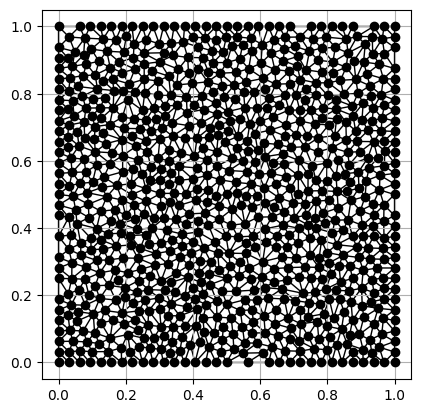

In [17]:
gedim.PlotMesh(mesh)

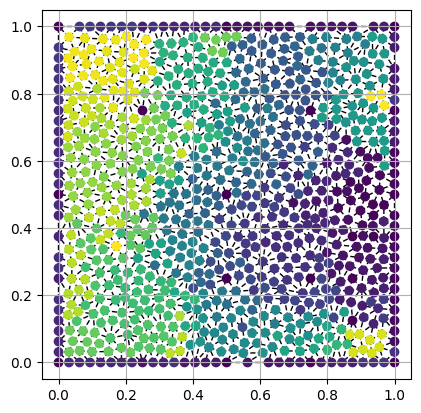

In [18]:
gedim.PlotDofs(mesh, dofs, strongs)

### Set Newton parameters

In [19]:
# Variable using in the newton iteration
residual_norm = 1.0
solution_norm = 1.0
newton_tol = 1.0e-8 # Tolerance for the stopping criteria
max_iterations = 100
num_iteration = 1
rel_error = 1 # To enter in the loop

| Variable   | What it represents                          | Initialization   | Use                                   |
|------------|---------------------------------------------|------------------|---------------------------------------|
| `u_k`      | Unknown **numerical** solution (free DOFs)  | $u = 0$          | Iterative solver input                |
| `u_strong` | **conditional** solution (Dirichlet conditions) | $u = 0$          | Used to impose values on edges        |

In [20]:
# Set Initial Solution - Starting from null solution

# Initialization of the guess of the solution --> the NM converges rapidly if we start not far away from the solution
u_k = np.zeros(problemData['NumberDOFs'], order='F') 

u_strong = np.zeros(problemData['NumberStrongs'], order='F') # Vector containing the strongly imposed components of the solution, 
                                                            # i.e. those corresponding to Dirichlet conditions

### Run Newton Algorithm

**Why is this being done?**  `du_normL2 = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib)`

In this context **you are not looking for the error with respect to the analytical solution**, but rather you want to calculate:

$$
\| \delta u \|_{L^2} = \| u^{(k+1)} - u^{(k)} \|_{L^2}
$$

To do this, simply pass `du` as the **numerical solution** and the function `Zeros` as the **exact solution**:

```python
ComputeErrorL2(Zeros, du, ...) = || du - 0 || = || du ||
```

This is done to monitor **how much the solution changes with each iteration**. It is a common **stop criterion** for non-linear methods.

| Error | Meaning | When to use it |
| -------------------------- | ------------------------------------------------------------------------------------ | --------------------------------------------------------------------------- |
| `rel_error_L2` | Relative error in norm $L^2$: average accuracy of the solution | When you are interested in the **average value solution**, e.g. states |
| `rel_error_H1` | Relative error in norm $H^1$: accuracy including derivatives | When you are interested in **energy** or **derivative** (e.g. gradients, flows) |
| `residual_norm / u_normL2` | Relative residual in $L^2$: how well the solution satisfies the system (not accuracy) | Serves as a **criterion of convergence of Newton's method** |

In [21]:
# ERROR COMPUTATION USING EXACT SOLUTION 
# OPTION 1
sample_mu_0 = np.random.uniform(0.1, 1, 1) # Uniform sampling in mu_Rang of 100 samples
sample_mu_1 = np.random.uniform(0.1, 1, 1)

snapshots_matrix = []
zero = np.zeros(713, order='F') # Null function

for mu_0, mu_1 in zip(sample_mu_0, sample_mu_1):
    
    # Set Newton parameter at each change of the parameter
    residual_norm = 1.0
    solution_norm = 1.0
    num_iteration = 1
    rel_error = 1

    # Iterative step - Setting a relative tollerance
    while num_iteration < max_iterations and residual_norm > newton_tol * solution_norm: 

        # 1- Left side of the equation
        
        # Linear
        [stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Elliptic_a, problemData, lib) # Indipendent from mu_0 & mu_1
        # Non linear 
        [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Elliptic_c, Elliptic_non_linear_c, u_k, u_strong, problemData, lib)
       
        # 2- Right hand side of the function
        
        # Linear part
        forcingTerm_g = gedim.AssembleForcingTerm(Elliptic_exactSolution_g, problemData, lib)
        # Non linear part
        forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Elliptic_non_linear_f, u_k, u_strong, problemData, lib)
        forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Elliptic_non_linear_der_f, u_k, u_strong, problemData, lib)
    
        # Solving with the LU solver because we're in a generic setting (no idea of the structure of the matrix)
        du = gedim.LUSolver(stiffness + reaction, \
                forcingTerm_g - forcingTerm_v - forcingTerm_der_v, \
                lib)
        
        u_k = u_k + du # Update
        
        du_normL2 = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib) 
        
        # Compute the error wrt the exact solution
        u_errorL2 = gedim.ComputeErrorL2(Elliptic_exactSolution, u_k, u_strong, lib)
        u_exact_errorL2 = gedim.ComputeErrorL2(Elliptic_exactSolution, zero, u_strong, lib)
        u_errorH1 = gedim.ComputeErrorH1(Elliptic_exactDerivativeSolution, u_k, u_strong, lib)
    
        # Compute the norm if we do NOT have the exact solution
        u_normL2 = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib) # L2 norm of du 
        # u_normH1 = gedim.ComputeErrorH1(ZerosDerivative, u_k, u_strong, lib) # H1 norm of du
        u_exact_errorH1 = gedim.ComputeErrorH1(Elliptic_exactDerivativeSolution, zero, u_strong, lib)

        # wrt the exact solution
        solution_norm = u_exact_errorL2
        residual_norm = u_errorL2

        rel_error_L2 = u_errorL2 / u_exact_errorL2
        rel_error_H1 = u_errorH1 / u_exact_errorH1
        
        num_iteration = num_iteration + 1

    snapshots_matrix.append(np.copy(u_k))
    # Print at the end of the iteration before the change of the parameter
    print(f"{'mu_0':<10} {'mu_1':<10} {'dofs':<8} {'h':<10} {'rel_res':<12} {'iters':<6} {'rel_err_L2':<14} {'rel_err_H1':<14} {'rel_sol_norm':<14}")
    print(f"{mu_0:<10.4f} {mu_1:<10.4f} {problemData['NumberDOFs']:<8d} {problemData['H']:<10.2e} "
      f"{residual_norm / u_normL2:<12.2e} {num_iteration:<6d} {rel_error_L2:<14.2e} {rel_error_H1:<14.2e} {solution_norm / u_normL2:<14.2e}")

    


snapshots_matrix = np.array(snapshots_matrix)
print(f"snapshots_matrix.shape: {snapshots_matrix.shape}")

mu_0       mu_1       dofs     h          rel_res      iters  rel_err_L2     rel_err_H1     rel_sol_norm  
0.5656     0.9523     713      6.43e-02   2.65e-03     100    2.64e-03       5.13e-02       1.00e+00      
snapshots_matrix.shape: (1, 713)


In [22]:
# Just to check the final u_k, mu_0, mu_1
last_u_k_exact = u_k
last_mu_0 = mu_0
last_mu_1 = mu_1

print(f"last_mu_0: {last_mu_0}")
print(f"last_mu_1: {last_mu_1}")

last_mu_0: 0.5655680954619303
last_mu_1: 0.9522663434333327


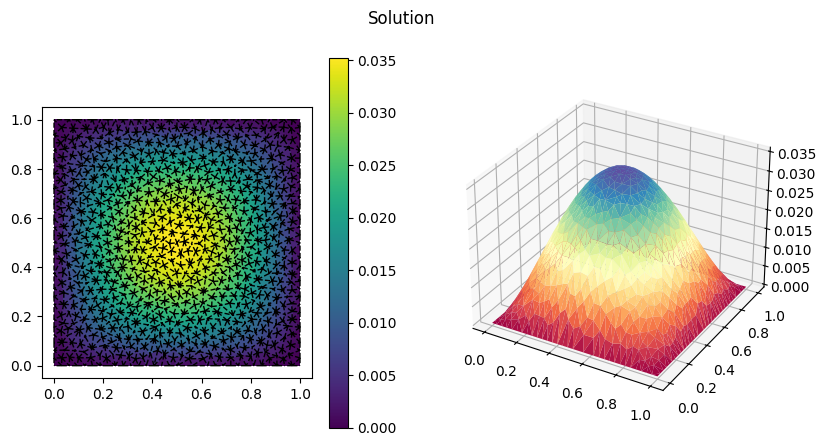

In [23]:
# Plot and show the solution
gedim.PlotSolution(mesh, dofs, strongs, last_u_k_exact, u_strong)
[numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(last_u_k_exact, u_strong, lib)

# To export the solution
gedim.ExportSolution(Elliptic_exactSolution, last_u_k_exact, u_strong, lib)
gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib) # To export solutions on paraview

### Passage from Strong Formulation to Weak Formulation and Newton Scheme for the proble g_1

Starting from the strong form of the PDE, we multiply both sides of the equation by a test function $ v \in V $, where $ V $ is a suitable function space (typically $ H^1(\Omega) $ or similar). Then, we integrate the resulting expression over the spatial domain $ \Omega $.

To handle the diffusion term, we apply integration by parts (or the divergence theorem), which transfers the derivative from the solution $ u $ to the test function $ v $, thereby reducing the differentiability requirement on $ u $. For the advection term, we apply the divergence theorem as well, which is often useful when dealing with convective fluxes.

After these transformations, we obtain the weak formulation of the problem, which is better suited for numerical approximation, especially in the finite element framework.

**Consider the homogeneous Dirichlet problem for the equation:**
$$-\Delta u(X; \mu)+\frac{\mu_0}{\mu_1} (e^{\mu_1 u(X;\mu)}-1) = g(X;\mu) \quad \text{in } \Omega \text{ where } X = (x,y)$$
$$u = 0 \quad \text{on } \partial \Omega$$
where $\Omega \subset \mathbb{R}^2$ is a bounded domain with a regular boundary $\partial \Omega$. We seek a solution $u$ in $H_0^1(\Omega)$.

**Weak Formulation.**
Find $u \in H_0^1(\Omega)$ such that for every $v \in H_0^1(\Omega)$:
$$\int_{\Omega} \nabla u \cdot \nabla v \, dX + \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u} -1) v \, dX - \int_{\Omega} g v \, dX = 0$$
Hence, the weak formulation is:
$$\int_{\Omega} \nabla u \cdot \nabla v \, dX + \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u} -1) v \, dX = \int_{\Omega} g v \, dX$$
where on the left can be found the unkown $u$ and on the right the forcing term.

**Definition of the Nonlinear Operator.**
Define the operator $F: H_0^1(\Omega) \to (H_0^1(\Omega))'$ such that for $u \in H_0^1(\Omega)$ and $v \in H_0^1(\Omega)$:
$$F(u)[v] = \int_{\Omega} \nabla u \cdot \nabla v \, dX + \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u} -1) v \, dX - \int_{\Omega} g v \, dX$$

**Fréchet Derivative of $F(u)$.**
Calculate the Fréchet derivative $DF(u)[\delta u] \in (H_0^1(\Omega))'$ for an increment $\delta u \in H_0^1(\Omega)$. For every $v \in H_0^1(\Omega)$:
$$DF(u)[\delta u][v] = \lim_{\epsilon \to 0} \frac{F(u + \epsilon \delta u)[v] - F(u)[v]}{\epsilon}$$
Consider each term of $F(u)[v]$ separately.

1.  **Linear Term.** $F_1(u)[v] = \int_{\Omega} \nabla u \cdot \nabla v \, dX$.
    $$DF_1(u)[\delta u][v] = \int_{\Omega} \nabla \delta u \cdot \nabla v \, dX$$

2.  **Nonlinear Term.** $F_2(u)[v] = \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u} -1) v \, dX$.
    The Fréchet derivative of $F_2(u)$ is given by:
    $$DF_2(u)[\delta u][v] = \lim_{\epsilon \to 0} \frac{F_2(u + \epsilon \delta u)[v] - F_2(u)[v]}{\epsilon}$$
    **Expansion of $F_2(u + \epsilon \delta u)[v]$.**
    \begin{align*}
    F_2(u + \epsilon \delta u)[v] &= \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 (u + \epsilon \delta u)} - 1) v \, dX \\
    &= \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u} e^{\mu_1 \epsilon \delta u} - 1) v \, dX
    \end{align*}
    **Then**
    $$
    F_2(u + \epsilon \delta u)[v] - F_2(u)[v] = \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u} e^{\mu_1 \epsilon \delta u} - 1) v \, dX - \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u} - 1) v \, dX
    $$
    $$= \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u} e^{\mu_1 \epsilon \delta u} - e^{\mu_1 u}) v \, dX = \int_{\Omega} \frac{\mu_0}{\mu_1} e^{\mu_1 u} (e^{\mu_1 \epsilon \delta u} - 1) v \, dX
    $$

    **Division by $\epsilon$.**
    $$\frac{F_2(u + \epsilon \delta u)[v] - F_2(u)[v]}{\epsilon} = \int_{\Omega} \frac{\mu_0}{\mu_1} e^{\mu_1 u} \frac{(e^{\mu_1 \epsilon \delta u} - 1)}{\epsilon} v \, dX$$
    **Notable Limit.**
    We use the notable limit $\lim_{t \to 0} \frac{e^{at} - 1}{t} = a$. In our case, $t = \epsilon$ and $a = \mu_1 \delta u(X)$. Thus:
    $$\lim_{\epsilon \to 0} \frac{e^{\mu_1 \epsilon \delta u(X)} - 1}{\epsilon} = \mu_1 \delta u(X)$$
    **Passing to the Limit.**
    $$DF_2(u)[\delta u][v] = \lim_{\epsilon \to 0} \int_{\Omega} \frac{\mu_0}{\mu_1} e^{\mu_1 u(X)} \frac{(e^{\mu_1 \epsilon \delta u(X)} - 1)}{\epsilon} v(X) \, dX$$
    Assuming we can interchange the limit and the integral (which requires appropriate regularity conditions), we obtain:
    $$DF_2(u)[\delta u][v] = \int_{\Omega} \frac{\mu_0}{\mu_1} e^{\mu_1 u(X)} (\mu_1 \delta u(X)) v(X) \, dX = \int_{\Omega} \mu_0 e^{\mu_1 u(X)} \delta u(X) v(X) \, dX$$

3.  **Term Independent of $u$.** $F_3(u)[v] = - \int_{\Omega} g v \, dX$.
    $$DF_3(u)[\delta u][v] = 0$$

**The Jacobian Operator (Fréchet Derivative) of $F(u)$ is therefore**
$$DF(u)[\delta u][v] = \int_{\Omega} \nabla \delta u \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 u} \delta u v \, dX$$

**Newton Scheme.**
The Newton scheme to find the root of $F(u) = 0$ is given by:
$$DF(u_k)[\delta u] = -F(u_k)$$
where $u_k$ is the approximation at the $k$-th iteration and $\delta u_k = u_{k+1} - u_k$ is the increment to be found. In variational form, this is written:

Find $\delta u_k \in H_0^1(\Omega)$ such that for every $v \in H_0^1(\Omega)$:
$$\left( \int_{\Omega} \nabla \delta u_k \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 u_k} \delta u_k v \, dX \right) * \delta u = - \left( \int_{\Omega} \nabla u_k \cdot \nabla v \, dX + \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u_k} -1) v \, dX - \int_{\Omega} g v \, dX \right)$$
**Rewriting the equation for the next iteration $u_{k+1} = u_k + \delta u_k$.**
Find $u_{k+1} \in H_0^1(\Omega)$ such that for every $v \in H_0^1(\Omega)$:
$$
\int_{\Omega} \nabla (u_{k+1} - u_k) \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 u_k} (u_{k+1} - u_k) v \, dX = - \int_{\Omega} \nabla u_k \cdot \nabla v \, dX - \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u_k} -1) v \, dX + \int_{\Omega} g v \, dX$$

**Rearranging the terms, we obtain the variational form of the linear system to be solved at each Newton iteration to find $u_{k+1}$:**$$\int_{\Omega} \nabla u_{k+1} \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 u_k} u_{k+1} v \, dX = \int_{\Omega} \nabla u_k \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 u_k} u_k v \, dX - \int_{\Omega} \nabla u_k \cdot \nabla v \, dX - \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u_k} -1) v \, dX + \int_{\Omega} g v \, dX$$

**Which simplifies to**

$$\int_{\Omega} \nabla u_{k+1} \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 u_k} u_{k+1} v \, dX = \int_{\Omega} \mu_0 e^{\mu_1 u_k} u_k v \, dX - \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u_k} -1) v \, dX + \int_{\Omega} g v \, dX$$

#### Analisys of all the term of the system

$$\left( \int_{\Omega} \nabla \delta u_k \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 u_k} \delta u_k v \, dX \right) * \delta u = - \left( \int_{\Omega} \nabla u_k \cdot \nabla v \, dX + \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u_k} -1) v \, dX - \int_{\Omega} g v \, dX \right)$$

1. Left-hand side (Jacobian applied to Newton increment):
       
    **Diffusion term**:  $
      \int_{\Omega} \nabla \delta u_k \cdot \nabla v \, dX
      $
      
    **Nonlinear reaction term** (derivative of the exponential term):  $
      \int_{\Omega} \mu_0 e^{\mu_1 u_k} \delta u_k v \, dX
      $

2. Right-hand side (Nonlinear residual at step \( u_k \)):

    **Diffusion term**:  $
      \int_{\Omega} \nabla u_k \cdot \nabla v \, dX
      $
      
    **Nonlinear reaction term**:  $
      \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u_k} -1) v \, dX
      $
      
    **Source term**:  $
      \int_{\Omega} g v \, dX
      $

In [24]:
# Definition of Burger_f related to Lab12

# Definition of the forcing term g_1
def Elliptic_g_1(numPoints, points): 
    matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double) # X
    # g_1(X,mu) = 100*sin(2pi*x)*cos(2pi*y), X=(x,y)
    values_g = 100*np.sin(2*np.pi*matPoints[0,:])*np.cos(2*np.pi*matPoints[1,:])
    return values_g.ctypes.data

In [25]:
# RELATIVO A G_1

# OPTION 1
sample_mu_0 = np.random.uniform(0.1, 1, 1) # Uniform sampling in mu_Rang of 100 samples
sample_mu_1 = np.random.uniform(0.1, 1, 1)

snapshots_matrix = []

for mu_0, mu_1 in zip(sample_mu_0, sample_mu_1):
    
    # Set Newton parameter at each change of the parameter
    residual_norm = 1.0
    solution_norm = 1.0
    num_iteration = 1

    # Iterative step - Setting a relative tollerance
    while num_iteration < max_iterations and residual_norm > newton_tol * solution_norm: 

        # 1- Left side of the equation
        
        # Linear
        [stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Elliptic_a, problemData, lib) # Indipendent from mu_0 & mu_1
        # Non linear 
        [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Elliptic_c, Elliptic_non_linear_c, u_k, u_strong, problemData, lib)
       
        # 2- Right hand side of the function
        
        # Linear part
        forcingTerm_g = gedim.AssembleForcingTerm(Elliptic_g_1, problemData, lib)
        # Non linear part
        forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Elliptic_non_linear_f, u_k, u_strong, problemData, lib)
        forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Elliptic_non_linear_der_f, u_k, u_strong, problemData, lib)
    
        # Solving with the LU solver because we're in a generic setting (no idea of the structure of the matrix)
        # CAN WE DONE BETTER?
        du = gedim.LUSolver(stiffness + reaction, \
                forcingTerm_g - forcingTerm_v - forcingTerm_der_v, \
                lib)
        
        u_k = u_k + du # Update
        
        du_normL2 = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib) 
    
        # Compute the norm if we do NOT have the exact solution
        u_normL2 = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib)
        u_normH1 = gedim.ComputeErrorH1(ZerosDerivative, u_k, u_strong, lib)
        
        solution_norm = u_normL2
        residual_norm = du_normL2
        
        
        num_iteration = num_iteration + 1

    snapshots_matrix.append(np.copy(u_k))
    # Print at the end of the iteration before the change of the parameter
    print(f"{'mu_0':<10} {'mu_1':<10} {'dofs':<8} {'h':<10} {'rel_res':<12} {'iters':<6} {'rel_err_L2':<14} {'rel_err_H1':<14} {'rel_sol_norm':<14}")
    print(f"{mu_0:<10.4f} {mu_1:<10.4f} {problemData['NumberDOFs']:<8d} {problemData['H']:<10.2e} "
      f"{residual_norm / u_normL2:<12.2e} {num_iteration:<6d} {rel_error_L2:<14.2e} {rel_error_H1:<14.2e} {solution_norm / u_normL2:<14.2e}")


snapshots_matrix = np.array(snapshots_matrix)
print(f"snapshots_matrix.shape: {snapshots_matrix.shape}")

mu_0       mu_1       dofs     h          rel_res      iters  rel_err_L2     rel_err_H1     rel_sol_norm  
0.7889     0.3542     713      6.43e-02   1.56e-09     8      2.64e-03       5.13e-02       1.00e+00      
snapshots_matrix.shape: (1, 713)


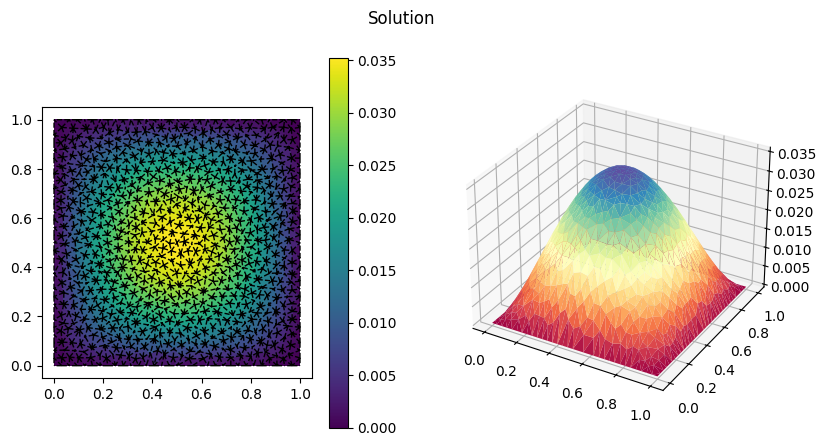

In [26]:
# Plot and show the solution
gedim.PlotSolution(mesh, dofs, strongs, last_u_k_exact, u_strong)
[numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(last_u_k_exact, u_strong, lib)

[numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(u_k, u_strong, lib)
gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib) # To export solutions on paraview


DA QUI ABBIAMO LINEARIZZATO CON NEWTON PROCEDIAMO NORMALMENTE...

### 🔁 Riassunto: cosa abbiamo fatto fino a qui?

Per ogni coppia $\mu = (\mu_0, \mu_1)$:

* Abbiamo risolto numericamente il problema
* Abbiamo ottenuto una soluzione $u_k$ (un vettore di dimensione pari ai DOFs FEM)
* L’ultimo plot che mostra solo **una** di queste soluzioni che abbiamo ottenuto

Quindi ora abbiamo gli *snapshots* che possiamo usare per la POD.

### 1. POD


**NB** In questo caso NON dobbiamo usare il supremizer perchè il nostro problema, pur essendo non lineare, non è di tipo sella nodo.
More info in https://chatgpt.com/share/68273d55-91b0-8005-96fd-237e81c3ff7e.

In [27]:
# We assemble here the linear system
[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Elliptic_a, problemData, lib)
inner_product = stiffness 

# Definitio of the covariance matrix
C = snapshots_matrix @ inner_product @ np.transpose(snapshots_matrix) 

In [28]:
# Eigenvalue problem

tol = 1. - 1e-7

L_e, VM_e = np.linalg.eig(C)
eigenvalues = []
eigenvectors = []

for i in range(len(L_e)):
  eig_real = L_e[i].real
  eig_complex = L_e[i].imag
  assert np.isclose(eig_complex, 0.) # We need a symmetic positive definite matrix: all eigenvalues real and positive
  eigenvalues.append(eig_real)
  eigenvectors.append(VM_e[i].real)


total_energy = sum(eigenvalues) # Sum of all the eigenvalues
retained_energy_vector = np.cumsum(eigenvalues) # Cumulative sum (summing until n)
relative_retained_energy = retained_energy_vector/total_energy # "Percentage"

# The IDEA is: we have a tol = 1 - 1e-7, the first time that relative_retained_energy 
# (that is the sum of the eigenvalue) is
# bigger than the tol, I can stop the computation and study the problem in 
# that number of dimenison
# Hence, all the other eigenvalue (and so direction) are NOT relevant to 
# compute the solution

# We want the first term for that the relative_retained_energy is less then 1 - 1e-7
if all(flag==False for flag in relative_retained_energy>= tol): 
  N = N_max
else:
  N = np.argmax(relative_retained_energy >= tol) + 1 # Python works from 0, but the basis goes from 1

# I need 3 basis (see the resutl) to show everything, this means that with 3 
# eigenvalues we reach the condition, and all the other are very very small (irrelevant)
print("The reduced dimension is", N) 

The reduced dimension is 1


In [29]:
# Create the basis function matrix
basis_functions = []
for n in range(N):
  eigenvector =  eigenvectors[n]
  
  # basis = (1/np.sqrt(snapshot_num))*np.transpose(snapshot_matrix)@eigenvector  
  # (This is the one of the book!!)
  
  basis = np.transpose(snapshots_matrix)@eigenvector
  norm = np.sqrt(np.transpose(basis) @ inner_product @ basis) # ||u||_H^1 = u'Xu 
  
  basis /= norm # Normalizing
  basis_functions.append(np.copy(basis)) # Have all together all the basis

basis_functions = np.transpose(np.array(basis_functions))

In [30]:
# ASSEMBLE THE LINEAR SYSTEM OFFLINE
# Reduce operator
[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Elliptic_a, problemData, lib)
reduced_stiff = np.transpose(basis_functions) @ stiffness @ basis_functions

# Assemble the forcing term (all the right part of the equation)
forcingTerm_g = gedim.AssembleForcingTerm(Elliptic_g_1, problemData, lib) # NO PARAMETRI
forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Elliptic_non_linear_der_f, u_k, u_strong, problemData, lib) # NO PARAMETRI

reduced_forcingTerm_g =  np.transpose(basis_functions) @ forcingTerm_g
reduced_forcingTerm_der_v =  np.transpose(basis_functions) @ forcingTerm_der_v 

### OFFLINE STOP

In [31]:
### ONLINE START
# Fissati casualmente ONLINE
# mu_0:  0.3544776894466156 mu_1:  0.5238513217014148
mu_0 = 0.2
mu_1 = 0.8

# Assemble reaction online
[reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Elliptic_c, Elliptic_non_linear_c, u_k, u_strong, problemData, lib) # Sì PARAMETRI
reduced_react = np.transpose(basis_functions) @ reaction @ basis_functions # Projection

# Assemble forcing term online
forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Elliptic_non_linear_f, u_k, u_strong, problemData, lib) # Sì PARAMETRI
reduced_forcingTerm_v =  np.transpose(basis_functions) @ forcingTerm_v 

reduced_lhs = reduced_stiff + reduced_react
reduced_rhs = reduced_forcingTerm_g - reduced_forcingTerm_v - reduced_forcingTerm_der_v

In [32]:
reduced_solution = np.linalg.solve(reduced_lhs, reduced_rhs)
print(reduced_solution)

[0.03380406]


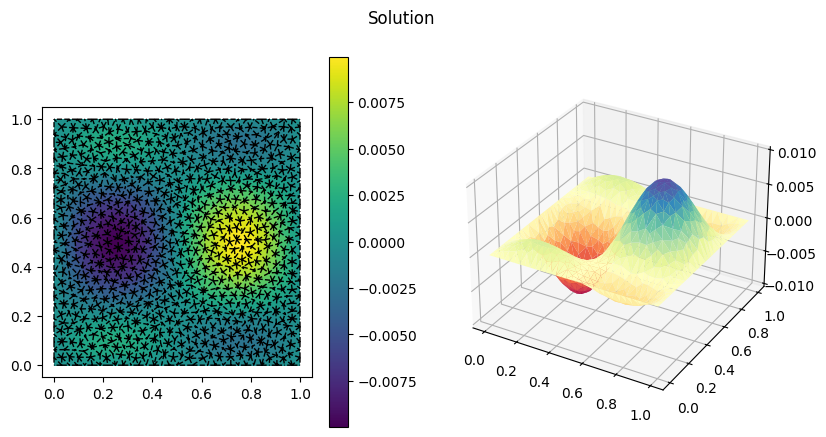

In [33]:
###### plot #######
# I need to project reduced_solution back to the finite element space (calligraphic N)
proj_reduced_solution = basis_functions @ reduced_solution 

# plot the reduce solution projected
gedim.PlotSolution(mesh, dofs, strongs, proj_reduced_solution, np.zeros(problemData['NumberStrongs'])) 
#gedim.ExportSolution(Elliptic_exactSolution, u_k, u_strong, lib) CAPIRE COME E SE ESPORTARLA

In [34]:
######### def error functions ######

# Compute the error for the solution, we want to compute separate error for velocity and for pressure
def compute_error(fom_solution, rom_solution_FE_basis, inner_product=None, type_err="relative"):
    
    error_function_u = fom_solution - rom_solution_FE_basis
    
    if inner_product == None:
      inner_product_matrix = np.identity(fom_solution.shape[0])
    else:
      inner_product_matrix = inner_product
    
    error_norm_squared_component = np.transpose(error_function_u) @ inner_product_matrix @ error_function_u
    absolute_error = np.sqrt(abs(error_norm_squared_component))
    
    if type_err == "absolute":
      return absolute_error
    
    else:
      full_solution_norm_squared_component = np.transpose(fom_solution) @  inner_product_matrix @ fom_solution
      relative_error = absolute_error/np.sqrt(abs(full_solution_norm_squared_component))
    
      return relative_error

In [35]:
### compute error - As always
import time

abs_err_u = []
rel_err_u = []

testing_set = np.random.uniform(low=0.1, high=1, size=(100, 2))
speed_up = []

print("Computing error and speedup analysis")

for mu in testing_set:
    mu_0 = mu[0]
    mu_1 = mu[1]
    
    # FULL
    start_time_assemble = time.time()
    [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Elliptic_c, Elliptic_non_linear_c, u_k, u_strong, problemData, lib)
    forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Elliptic_non_linear_f, u_k, u_strong, problemData, lib)
    time_assemble = time.time() - start_time_assemble

    lhs = stiffness + reaction
    rhs = forcingTerm_g - forcingTerm_v - forcingTerm_der_v
    
    start_fom = time.time()
    full_solution = gedim.LUSolver(lhs, rhs, lib)
    time_fom = time.time() - start_fom
    
    # REDUCED 
    reduced_forcingTerm_v =  np.transpose(basis_functions) @ forcingTerm_v # mu_0, mu_1 dipendent
    reduced_react = np.transpose(basis_functions) @ reaction @ basis_functions # mu_0, mu_1 dipendent
    
    reduced_lhs = reduced_stiff + reduced_react
    reduced_rhs = reduced_forcingTerm_g - reduced_forcingTerm_v - reduced_forcingTerm_der_v
    
    start_rom = time.time()
    reduced_solution = np.linalg.solve(reduced_lhs, reduced_rhs)
    time_rom = time.time() - start_rom
    
    speed_up.append((time_fom)/(time_rom))
    
    reduced_solution_FE_basis = basis_functions @ reduced_solution
    
    ### computing error
    
    abs_err_u_mu = compute_error(full_solution, reduced_solution_FE_basis, inner_product=inner_product, type_err="absolute")
    rel_err_u_mu = compute_error(full_solution, reduced_solution_FE_basis, inner_product=inner_product)
    abs_err_u.append(abs_err_u_mu)
    rel_err_u.append(rel_err_u_mu)

Computing error and speedup analysis


In [36]:
print("avarege relative error for velocity = ", np.mean(rel_err_u) )
print("avarege absolute error for velocity = ", np.mean(abs_err_u) )

print("avarege speed_up = ", np.mean(speed_up) )

print()

print(f"time_assemble: {time_assemble}")
print(f"time_fom: {time_fom}")
print(f"time_rom: {time_rom}")

avarege relative error for velocity =  0.6070788464562377
avarege absolute error for velocity =  0.012925450822550104
avarege speed_up =  65.71764018280628

time_assemble: 0.10049271583557129
time_fom: 0.004521608352661133
time_rom: 6.318092346191406e-05
